In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm

from datetime import datetime, timedelta

In [2]:
# Data provided by the course
PATH_ORDERS_BEFORE_DEC = "./Kurs/orders_before_dec.csv"
PATH_ORDERS_BEFORE_JAN = "./Kurs/orders_before_jan.csv"
PATH_SUBMISSION_DEC = "./Kurs/submission_dec.csv"
PATH_SUBMISSION_JAN = "./Kurs/submission_jan.csv"

PATH_TARGET_DEC = "./Kurs/gold_dec.csv"

# Data from online competition
PATH_ITEMS = "./Online/items.csv"

In [3]:
START_DATE = datetime(2020, 6, 1)
END_DATE = datetime(2020, 11, 30)
n_days = (END_DATE - START_DATE).days + 1

In [4]:
train_data = pd.read_csv(PATH_ORDERS_BEFORE_DEC, sep="|")
target_data = pd.read_csv(PATH_TARGET_DEC, sep="|")
items_features = pd.read_csv(PATH_ITEMS, sep="|")

In [5]:
train_data_merged = pd.merge(train_data, items_features, on="itemID")

0.16321201985058614

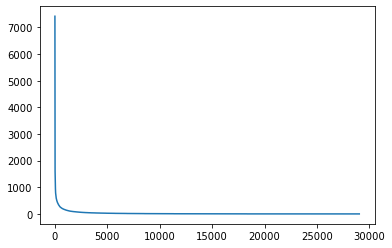

In [6]:
vals, cnts = np.unique(train_data_merged["itemID"].to_numpy(), return_counts=True)
cnts = sorted(cnts, reverse=True)
plt.plot(cnts)

n_samples = len(train_data_merged)

k = 100
np.sum(cnts[:k]) / n_samples

0.7858814205135759


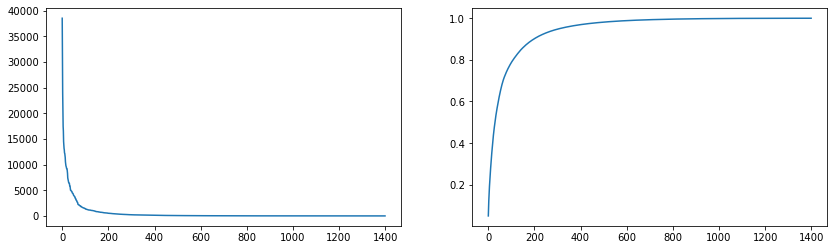

0.7958953555520505


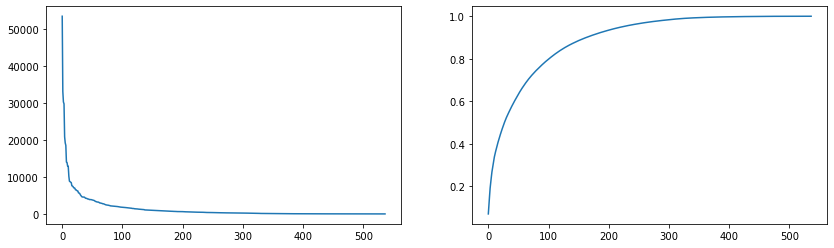

0.8650608566203165


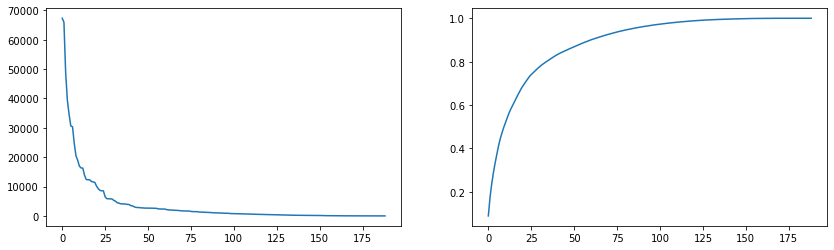

In [7]:
def plot_feature_frequency_and_importance(df, cnts, k):
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    cnts_sorted = sorted(cnts, reverse=True)
    axs[0].plot(cnts_sorted)

    n_samples = len(df)

    axs[1].plot(np.cumsum(cnts_sorted) / n_samples)
    print(np.sum(cnts_sorted[:k]) / n_samples)
    
    plt.show()

def one_hot_encode_top_features(df, feature, k):
    """
    This method one hot encodes the given feature but only keeps the k most frequent values.     
    """
    
    # Find the different values the feature can be and how often these values occur
    vals, cnts = np.unique(df[feature].to_numpy(), return_counts=True)
    
    plot_feature_frequency_and_importance(df, cnts, k)
    
    # Only keep the top k values that are used most often
    idxs = np.arange(len(cnts))
    idxs_sorted = [x for _, x in sorted(zip(cnts, idxs), reverse=True)]
    values_to_keep = vals[idxs_sorted][:k]
    
    # Replace all feature values that are not used frequently with -10
    feature_array = df[feature].to_numpy()
    feature_array[~np.isin(feature_array, values_to_keep)] = -10

    # One hot encode the feature and drop the entry with -10
    train_data_merged_ohe = pd.get_dummies(
        df, columns=[feature]
    )
    train_data_merged_ohe = train_data_merged_ohe.drop(columns=["{}_-10".format(feature)])
    
    return train_data_merged_ohe

def create_order_sequence(df):
    order_sequence = np.zeros(n_days)
    dates = df["date"].to_numpy()
    orders = df["order"].to_numpy()
    
    for date, number_orders in zip(dates, orders):
        dt_date = datetime.strptime(date, '%Y-%m-%d')
        idx = (dt_date - START_DATE).days
        order_sequence[idx] = number_orders
        
    return order_sequence
    
df_preprocessed = one_hot_encode_top_features(train_data_merged.copy(), "brand", 100)
df_preprocessed = pd.get_dummies(df_preprocessed, columns=["feature_1"])
df_preprocessed = pd.get_dummies(df_preprocessed, columns=["feature_2"])
df_preprocessed = one_hot_encode_top_features(df_preprocessed.copy(), "feature_3", 100)
df_preprocessed = pd.get_dummies(df_preprocessed, columns=["feature_4"])
df_preprocessed = one_hot_encode_top_features(df_preprocessed.copy(), "feature_5", 50)

In [8]:
df_preprocessed = df_preprocessed.drop(columns=["categories"])
df_preprocessed

,date,userID,itemID,order,brand_6,brand_18,brand_20,brand_73,brand_101,brand_127,...,feature_5_144,feature_5_146,feature_5_147,feature_5_151,feature_5_156,feature_5_159,feature_5_163,feature_5_175,feature_5_178,feature_5_190
0,2020-06-01,38769,3477,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-06-01,23570,3477,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-06-01,23495,3477,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-06-01,26073,3477,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-06-01,34302,3477,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767126,2020-11-30,19742,28822,2,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
767127,2020-11-30,15769,26453,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
767128,2020-11-30,16023,20609,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
767129,2020-11-30,43601,23190,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
userIDs = df_preprocessed["userID"].unique()

userIDs_target = target_data["userID"].unique()
itemIDs_target = target_data["itemID"].unique()

data = []

i = 0
for userID in tqdm(userIDs):
    if not userID in userIDs_target:
        continue
    user_data = df_preprocessed[df_preprocessed["userID"] == userID]
    itemIDs = user_data["itemID"].unique()
    
    for itemID in itemIDs:
        if not itemID in itemIDs_target:
            continue
            
        user_item_data = user_data[user_data["itemID"] == itemID]
        order_sequence = create_order_sequence(user_item_data)
        features = user_item_data.iloc[0][4:]
        
        np_user_item_data = np.hstack([userID, itemID, order_sequence, features])
        data.append(np_user_item_data)

100%|███████████████████████████████████████████████████████████████████████████| 45765/45765 [02:56<00:00, 258.67it/s]


In [74]:
order_sequence.shape

(183,)

In [10]:
data = np.array(data)
print(data.shape)

(94539, 457)


In [ ]:
target_data

In [53]:
# Only take the first two columns of "data", which contain userID and itemID
target = []
training_data = []

for index, (uid, iid) in tqdm(enumerate(data[:, :2])):
        
    res = target_data[(target_data["userID"] == uid) & (target_data["itemID"] == iid)]
    if len(res) == 0:
        continue
    else:
        training_data.append(data[index])
        target.append(res["prediction"].iloc[0])

94539it [01:30, 1043.53it/s]


In [54]:
training_data = np.array(training_data)
target = np.array(target)

In [55]:
training_data.shape, target.shape

((9745, 457), (9745,))

In [56]:
np.unique(target, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([6210,  960, 1167,  871,  537], dtype=int64))

In [67]:
import torch

th_training_data = torch.Tensor(training_data[:, 2:].astype(np.int64))
th_target = torch.Tensor(target.astype(np.int64))

torch.save(th_training_data, "X_train.th")
torch.save(th_target, "y_train.th")

In [71]:
th_target

tensor([0., 2., 0.,  ..., 4., 0., 1.])

In [72]:
df_preprocessed

,date,userID,itemID,order,brand_6,brand_18,brand_20,brand_73,brand_101,brand_127,...,feature_5_144,feature_5_146,feature_5_147,feature_5_151,feature_5_156,feature_5_159,feature_5_163,feature_5_175,feature_5_178,feature_5_190
0,2020-06-01,38769,3477,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-06-01,23570,3477,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-06-01,23495,3477,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-06-01,26073,3477,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-06-01,34302,3477,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767126,2020-11-30,19742,28822,2,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
767127,2020-11-30,15769,26453,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
767128,2020-11-30,16023,20609,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
767129,2020-11-30,43601,23190,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
